Notebook para evaluar los pesos del modelo empleando las métricas de evaluación.  
También se muestra la generación de análisis con las predicciones realizadas, mapas de calor, características de grietas, etc.

Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.


In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os
import seaborn as sns
import pandas as pd

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [2]:
### FUNCIONES
def get_annotation_masks(annotations):
    """ Convierte las máscaras de anotaciones en tensores de PyTorch redimensionados a 256x256 
    
    Parametros:
                annotations -- Lista de máscaras de anotaciones de NumPy
    Retorna:
                Lista de tensores de PyTorch redimensionados a 256x256
    """
    masks_each = []
    for annotation in annotations:
        # cross = (annotation == 2)
        # busbar = (annotation == 4)
        # crack = (annotation == 3)
        # dark = (annotation == 1)
        busbar = (annotation == 1) #1
        crack = (annotation == 2) #2
        cross = (annotation == 3) #3
        dark = (annotation == 4)  #4
        # Convertir las máscaras de NumPy a tensores de PyTorch
        cross_tensor = torch.from_numpy(cross.astype(np.float32))
        busbar_tensor = torch.from_numpy(busbar.astype(np.float32))
        crack_tensor = torch.from_numpy(crack.astype(np.float32))
        dark_tensor = torch.from_numpy(dark.astype(np.float32))
        
        # Apilar las máscaras
        stacked_masks = torch.stack([busbar_tensor, crack_tensor, cross_tensor, dark_tensor], dim=0)
        
# Redimensionar las máscaras apiladas: Se añade una dimensión batch al principio para usar interpolate
        stacked_masks = stacked_masks.unsqueeze(0)
        resized_masks = torch.nn.functional.interpolate(stacked_masks, size=(256, 256), mode='nearest')
        
        # Eliminar la dimensión batch y agregar el tensor redimensionado a la lista
        masks_each.append(resized_masks.squeeze(0))
    return masks_each


def show_comparison(pred_mask, true_mask, class_names):
    """ Muestra las máscaras predichas y verdaderas para cada clase en una fila de subgráficos

    Parametros:
                pred_mask -- Máscaras predichas
                true_mask -- Máscaras verdaderas
                class_names -- Nombres de las clases
    """
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, num_classes * 5))
    
    for i, class_name in enumerate(class_names):
        # Predicted mask for the class
        axes[i, 0].imshow(pred_mask[i], cmap='gray')
        axes[i, 0].set_title(f'Predicted Mask - {class_name}')
        axes[i, 0].axis('off')
        
        # True mask for the class
        axes[i, 1].imshow(true_mask[i], cmap='gray')
        axes[i, 1].set_title(f'True Mask - {class_name}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

# Calcular el IoU para una clase específica
def calculate_iou(pred_mask, true_mask):
    """ Calcula el Índice de Jaccard (IoU) para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Índice de Jaccard para la clase
    """
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    if union == 0:
        return float('nan')  # Si no hay ningún píxel verdadero o predicho en esta clase, devolver NaN
    return intersection / union

# Función para calcular Precision
def calculate_precision(pred_mask, true_mask):
    """ Calcula la Precisión para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Precisión para la clase
    """
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    predicted_positive = pred_mask.sum().item()
    if predicted_positive == 0:
        return float('nan')  # Si no hay ningún píxel predicho positivo, devolver NaN
    return true_positive / predicted_positive

# Función para calcular Recall
def calculate_recall(pred_mask, true_mask):
    """ Calcula la Sensibilidad (Recall) para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Sensibilidad (Recall) para la clase
    """
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    actual_positive = true_mask.sum().item()
    if actual_positive == 0:
        return float('nan')  # Si no hay ningún píxel verdadero positivo, devolver NaN
    return true_positive / actual_positive

# Función para calcular F1 Score
def calculate_f1_score(precision, recall):
    """ Calcula el F1 Score a partir de la Precisión y la Sensibilidad (Recall)

    Parametros:  
                precision -- Precisión  
                recall -- Sensibilidad (Recall)  
    Retorna:  
                F1 Score
    """
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        return float('nan')  # Si alguna de las métricas es NaN o la suma es 0, devolver NaN
    return 2 * (precision * recall) / (precision + recall)

# Función para evaluar las predicciones y calcular todas las métricas
def evaluate_predictions(pred_masks, true_masks):
    """ Evalua las predicciones y calcula las métricas de evaluación
    
    Parametros:
                pred_masks: Lista de máscaras predichas
                true_masks: Lista de máscaras verdaderas
    Retorna:
                Diccionario de métricas con las métricas de evaluación para cada
    """
    ious = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    precisions = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    recalls = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    f1_scores = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        for i, class_name in enumerate(['busbar', 'crack', 'cross', 'dark']):
            iou = calculate_iou(pred_mask[i], true_mask[i])
            precision = calculate_precision(pred_mask[i], true_mask[i])
            recall = calculate_recall(pred_mask[i], true_mask[i])
            f1_score = calculate_f1_score(precision, recall)
            
            ious[class_name].append(iou)
            precisions[class_name].append(precision)
            recalls[class_name].append(recall)
            f1_scores[class_name].append(f1_score)
    
    metrics = {}
    for class_name in ious:
        metrics[class_name] = {
            'IoU': np.nanmean(ious[class_name]),
            'Precision': np.nanmean(precisions[class_name]),
            'Recall': np.nanmean(recalls[class_name]),
            'F1 Score': np.nanmean(f1_scores[class_name])
        }
    return metrics

In [3]:

# Carpeta de imágenes
val_imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/DatasetFinal/resize/img'
#val_imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/CeldasIndividuales/Mono2_V40_I5_t28'
#val_imgs_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/img'
#D:\Documentos\Universidad de Cuenca\Trabajo de Titulación\Datasets_EL\CeldasIndividuales\Mono2_V40_I5_t28

# Carpeta de anotaciones
#val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/annotations'
val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/DatasetFinal/resize/ann'
#val_annotations_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/new_ann_v1'
images_val = [cv.imread(file) for file in list_images(val_imgs_path)]           #imágenes de validación
ann_val = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in list_images(val_annotations_path)]       # anotaciones de validación
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes de validación: {len(images_val)}')
print(f'Número de anotaciones de validación: {len(ann_val)}')


Número de imágenes de validación: 96
Número de anotaciones de validación: 96


In [4]:
# Transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])

# Mapa de colores para las diferentes clases de máscaras.
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

# Función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)

In [6]:
# Se define una función para crear un modelo DeepLab preentrenado.
def DeepLab_pretrained(num_classes):
    # Se carga el modelo DeepLab con una arquitectura ResNet50 preentrenada.
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

    # Se reemplaza el clasificador del modelo con un nuevo clasificador DeepLabHead.
    # El nuevo clasificador tiene 2048 características de entrada y 'num_classes' características de salida.
    deeplab.classifier = DeepLabHead(2048, num_classes)

    # Se devuelve el modelo modificado.
    return deeplab

In [ ]:
                ## Celda para DeepLab ##
imgset = myDataset(images_val, transform)

# Definición del dispositivo en el que se ejecutará el modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')

# Crea una instancia del modelo DeepLab con 5 canales de salida
model = DeepLab_pretrained(5)

# Envuelve el modelo en un objeto DataParallel
model = DataParallel(model).to(device)

# Cargar los pesos del modelo entrenado
weight_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/PesosGColab/deeplab.pt'
#model.load_state_dict(torch.load(weight_path, map_location=device))

# Coloca el modelo en modo de evaluación
#model.eval()

# Iniciar el manejador del modelo (ModelHandler) para DeepLab
modelhandler = ModelHandler(
    model=model,
    model_output='out',
    test_dataset=imgset,
    predict_only=True,
    batch_size_val=2,
    device=device,
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    save_name='deeplab_cell_prediction'
)
modelhandler.load_model(weight_path)
# Ejecución del modelo en el conjunto de datos de prueba
masks = modelhandler.predict(save=True)

In [10]:
from efficientunet import EfficientNet

unet = EfficientNet.from_name('efficientnet-b5', n_classes=5, pretrained=False)

In [25]:
                ## Celda para U-Net ##
# Crea el dataset
imgset = myDataset(images_val, transform)
# Carpeta de pesos del modelo
#weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'
weight_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/PesosGColab/unetv32.pt'
# Definición del dispositivo en el que se ejecutará el modelo. 

# Si hay una GPU disponible, se utilizará.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')
# Crea una instancia del modelo U-Net con 5 canales de salida. 
# Número de canales de salida = al número de clases
unet = construct_unet(5)
# Se "envuelve" el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

# Iniciar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, 
# la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar.
    model=unet,
    #model_output='out_deeplab',
    # El conjunto de datos que se utilizará para las pruebas.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo.
    device=device,
    # El directorio donde se guardarán los resultados. 
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. 
    save_name='Unetv31_cell_prediction_val'
)
# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)

# Ejecución del modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)

Dispositivo: cuda:0


100%|██████████| 48/48 [00:51<00:00,  1.08s/it]


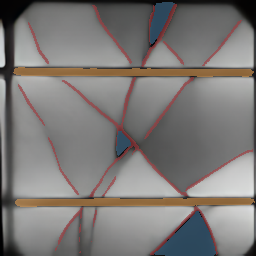

In [26]:
noCell = 27
true_masks = get_annotation_masks(ann_val)
# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)
# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images_val[noCell], masks_each[noCell])

In [22]:
# Calcular las métricas para las predicciones del modelo.
metrics = evaluate_predictions(masks_each, true_masks)

print("Métricas para las predicciones del modelo:")

for class_name, class_metrics in metrics.items():
    print(f'{class_name}:')
    for metric_name, value in class_metrics.items():
        print(f'  {metric_name}: {value:.4f}')

Métricas para las predicciones del modelo:
busbar:
  IoU: 0.8154
  Precision: 0.9016
  Recall: 0.8962
  F1 Score: 0.8978
crack:
  IoU: 0.4113
  Precision: 0.6266
  Recall: 0.5707
  F1 Score: 0.5824
cross:
  IoU: 0.0000
  Precision: 0.0000
  Recall: nan
  F1 Score: nan
dark:
  IoU: 0.6931
  Precision: 0.8234
  Recall: 0.8135
  F1 Score: 0.8219


C:\Users\Compustore\AppData\Local\Temp\ipykernel_9108\852043561.py:188: RuntimeWarning: Mean of empty slice
  'Recall': np.nanmean(recalls[class_name]),
C:\Users\Compustore\AppData\Local\Temp\ipykernel_9108\852043561.py:189: RuntimeWarning: Mean of empty slice
  'F1 Score': np.nanmean(f1_scores[class_name])


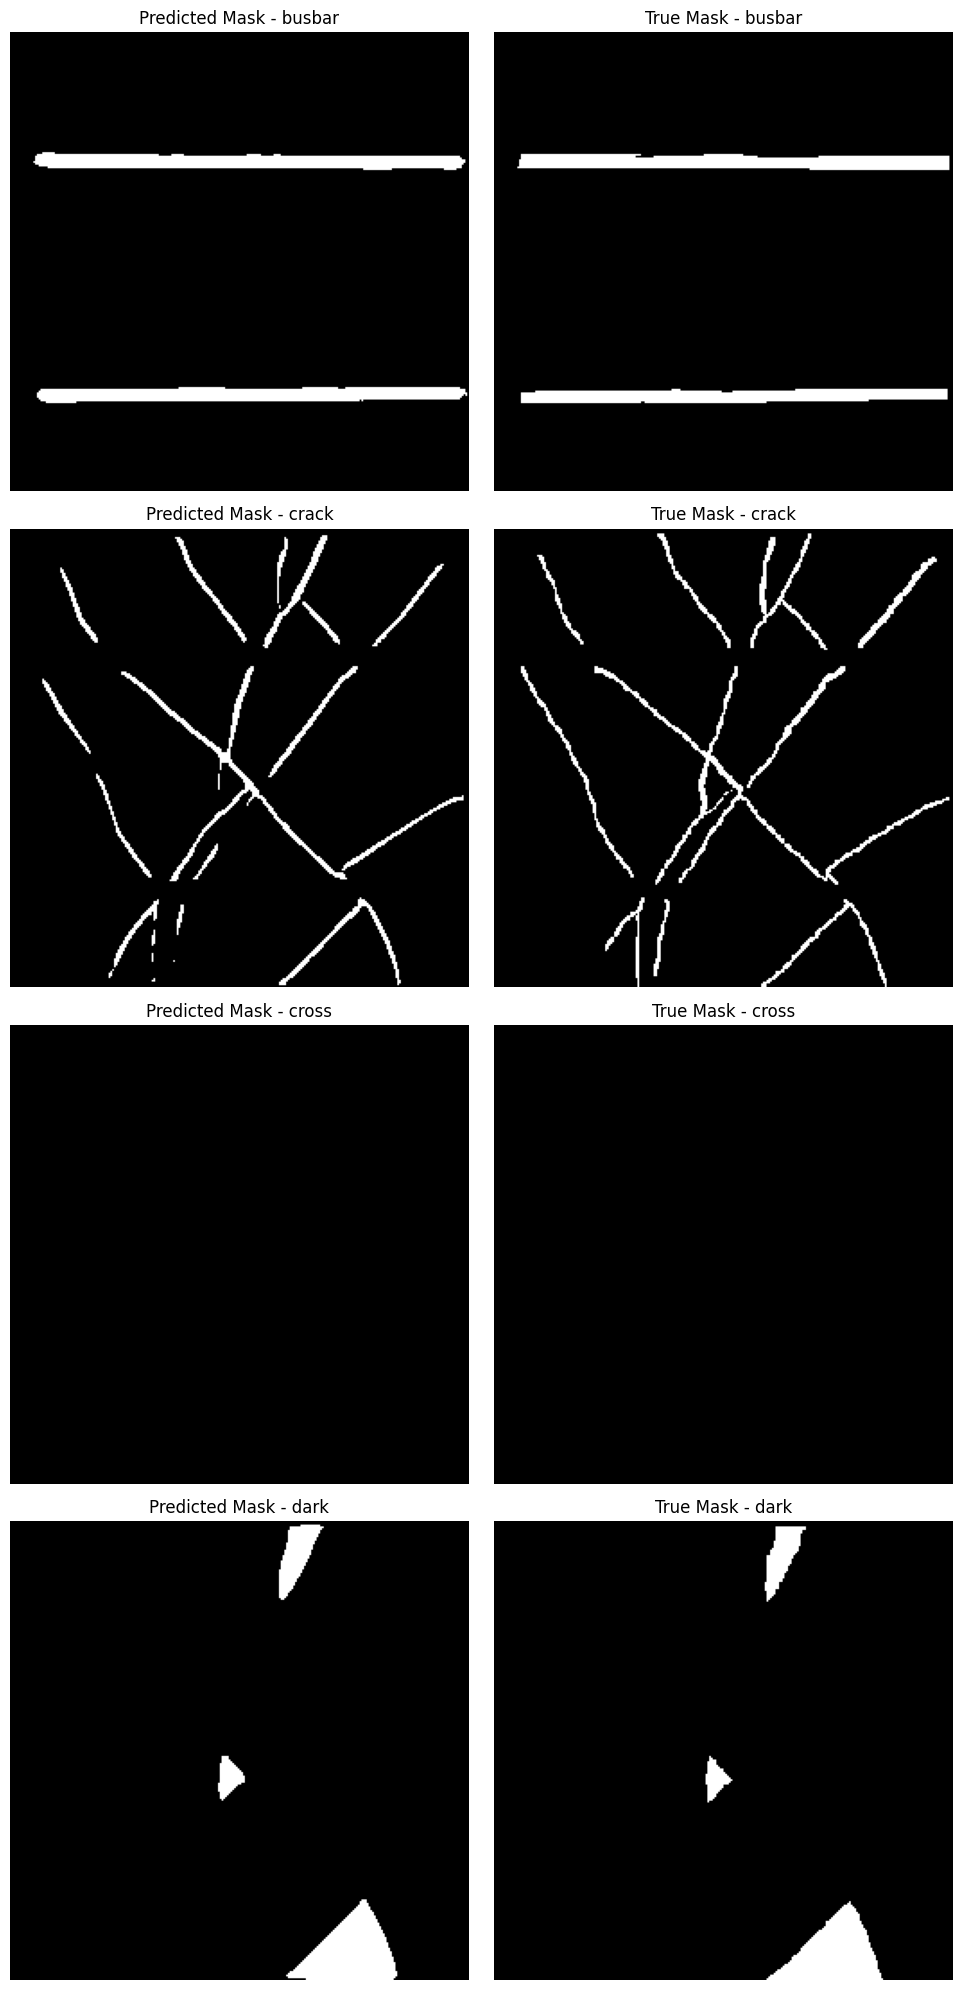

In [27]:
# Comparar una máscara predicha con la máscara verdadera
pred_mask = masks_each[noCell]  # Primera predicción del modelo
true_mask = true_masks[noCell]  # Primera máscara de anotación

# Nombres de las clases
class_names = ['busbar', 'crack', 'cross', 'dark']

# Mostrar la comparación
show_comparison(pred_mask, true_mask, class_names)

# Distribución espacial de las predicciones  

Permite la exploración de datos para el análisis de la distribución de etiquetas. Puede ser necesaria para la segmentación, la detección y otras tareas de visión artificial.

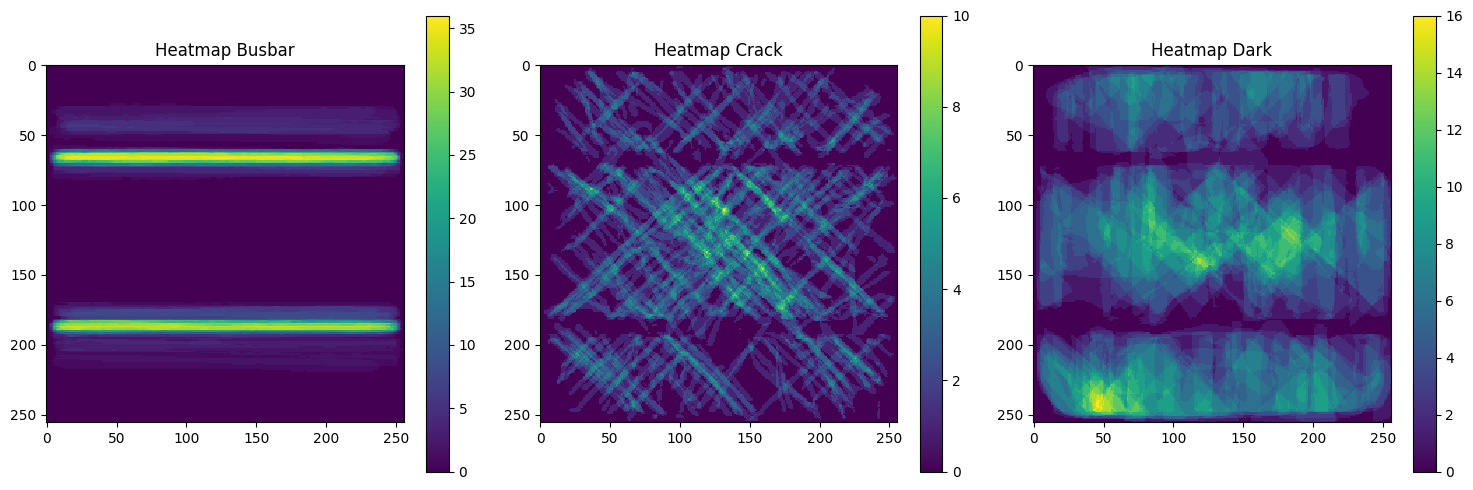

In [19]:
# Mapas de calor de las máscaras predichas
def generate_heatmap(masks_each, class_index):
    """
    Genera un mapa de calor para una clase específica combinando todas las predicciones.

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        class_index (int): Índice de la clase para la cual se desea generar el mapa de calor.
                           Por ejemplo, 0 para 'busbar', 1 para 'crack', 3 para 'dark'.

    Returns:
        np.ndarray: Mapa de calor normalizado.
    """
    # Sumar todas las máscaras correspondientes a la clase
    heatmap = np.sum([mask[class_index] for mask in masks_each], axis=0)
    
    # Normalizar el mapa de calor para que los valores estén entre 0 y 1
    #heatmap = combined_mask / combined_mask.max()
    
    return heatmap

# Generar mapas de calor para cada clase
heatmap_busbar = generate_heatmap(masks_each, class_index=0)  # Índice 0 para 'busbar'
heatmap_crack = generate_heatmap(masks_each, class_index=1)   # Índice 1 para 'crack'
heatmap_dark = generate_heatmap(masks_each, class_index=3)    # Índice 3 para 'dark'

# Visualizar los mapas de calor
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(heatmap_busbar, cmap='viridis', interpolation='nearest')
plt.title('Heatmap Busbar')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(heatmap_crack, cmap='viridis', interpolation='nearest')
plt.title('Heatmap Crack')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(heatmap_dark, cmap='viridis', interpolation='nearest')
plt.title('Heatmap Dark')
plt.colorbar()

plt.tight_layout()
plt.show()


Explicación:  
`generate_heatmap`: Esta función toma `masks_each` y un `class_index`, que corresponde al índice de la clase para la cual se desea generar el mapa de calor.  
Sumar máscaras: Se suma cada máscara de la clase indicada a lo largo de todas las predicciones para obtener una imagen acumulada.
Normalizar: El mapa de calor resultante se normaliza dividiendo por el valor máximo, asegurando que los valores estén entre 0 y 1.
Visualización: Los mapas de calor se visualizan utilizando plt.imshow con el mapa de color 'hot'.  
Este proceso generará tres mapas de calor que mostrarán las zonas comunes donde se detectan las clases busbar, crack, y dark.  

Explorar otros tipos de colormaps  
Además del colormap 'hot', existen muchos otros que puedes utilizar, dependiendo del efecto visual que desees lograr. Algunos de los colormaps más comunes y útiles son:

'viridis': Es el colormap por defecto en Matplotlib. Es perceptualmente uniforme, lo que significa que cambia de manera constante en términos de percepción visual.  
'plasma': Similar a viridis, pero con un rango de colores que va de morado a amarillo.  
'inferno': Un colormap que va de negro a amarillo, pasando por naranja y rojo.  
'magma': Similar a inferno, pero con un tono más oscuro, yendo de negro a blanco a través de morados oscuros.  
'cividis': Diseñado para ser perceptualmente uniforme para usuarios con daltonismo.   
'jet': Un colormap clásico, pero no recomendado en algunos contextos debido a que no es perceptualmente uniforme.  
'coolwarm': Un colormap que va de azul a rojo, útil para representar gradientes que van de frío a cálido.  

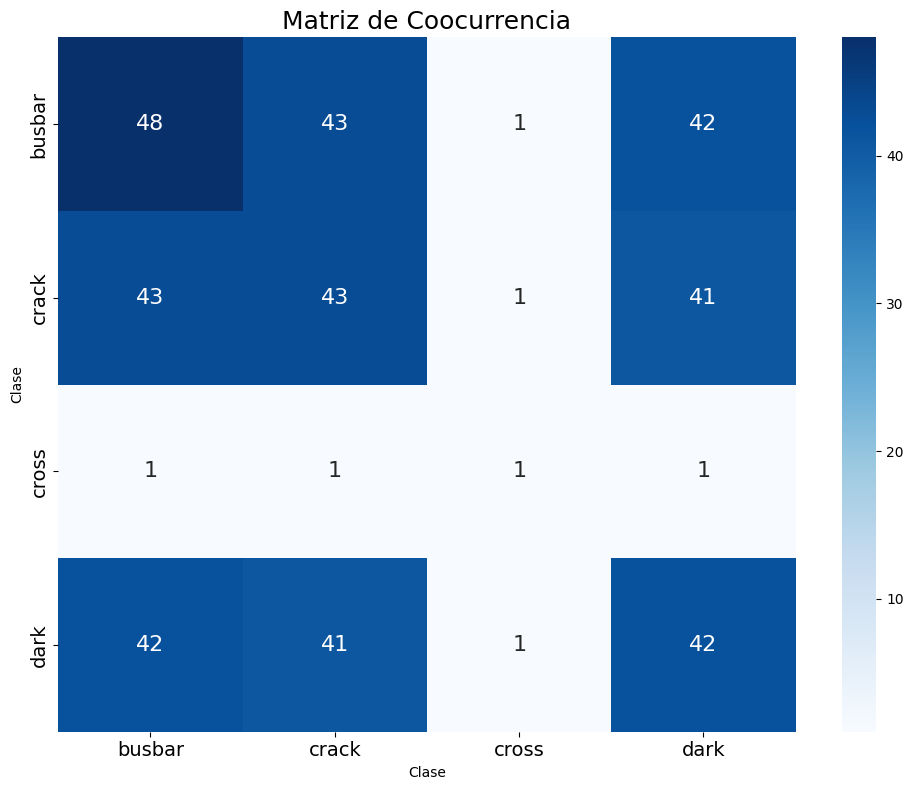

In [20]:
# Función para generar y mostrar una matriz de coocurrencia
def generate_cooccurrence_matrix(masks_each, n_classes):
    """
    Genera una matriz de coocurrencia para las clases en las imágenes.

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        n_classes (int): Número de clases en el conjunto de datos.

    Returns:
        np.ndarray: Matriz de coocurrencia.
    """
    cooccurrence_matrix = np.zeros((n_classes, n_classes), dtype=int)

    for masks in masks_each:
        # Convertir a NumPy si es un tensor de PyTorch
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()
        
        # Crear un conjunto de clases presentes en la imagen
        present_classes = set()
        for class_index in range(n_classes):
            if np.any(masks[class_index]):
                present_classes.add(class_index)
        
        # Actualizar la matriz de coocurrencia
        for class1 in present_classes:
            for class2 in present_classes:
                cooccurrence_matrix[class1, class2] += 1

    return cooccurrence_matrix

def plot_cooccurrence_matrix(cooccurrence_matrix, class_names, save_path=None):
    """
    Visualiza la matriz de coocurrencia y opcionalmente la guarda como imagen.

    Args:
        cooccurrence_matrix (np.ndarray): Matriz de coocurrencia.
        class_names (list): Lista de nombres de las clases.
        save_path (str, optional): Ruta del archivo donde se guardará la imagen. 
        Si es None, solo muestra la matriz.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16})
    plt.xlabel('Clase')
    plt.ylabel('Clase')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Matriz de Coocurrencia', fontsize=18)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def save_cooccurrence_matrix(cooccurrence_matrix, class_names, file_path):
    """
    Guarda la matriz de coocurrencia en un archivo CSV.

    Args:
        cooccurrence_matrix (np.ndarray): Matriz de coocurrencia.
        class_names (list): Lista de nombres de las clases.
        file_path (str): Ruta del archivo CSV donde se guardará la matriz.
    """
    df = pd.DataFrame(cooccurrence_matrix, index=class_names, columns=class_names)
    df.to_csv(file_path)


# Nombres de las clases
class_names = ['busbar', 'crack', 'cross', 'dark']
# Número de clases en el conjunto de datos
n_classes = 4  # Ajusta esto según tu conjunto de datos

# Generar la matriz de coocurrencia
cooccurrence_matrix = generate_cooccurrence_matrix(masks_each, n_classes)

# Visualizar la matriz de coocurrencia
plot_cooccurrence_matrix(cooccurrence_matrix, class_names)

reporte_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'
# Guardar la matriz de coocurrencia en un archivo CSV
#save_cooccurrence_matrix(cooccurrence_matrix, class_names, f'{reporte_path}/cooccurrence_matrix.csv')

In [66]:
# Función para generar estadísticas por imagen
def generate_image_statistics(masks_each, class_names):
    """
    Genera estadísticas por imagen en función de la cantidad de anotaciones para cada clase.

    Args:
        masks_each (list or np.ndarray or torch.Tensor): Lista de máscaras predichas para cada imagen.
        class_names (list): Lista de nombres de las clases.

    Returns:
        pd.DataFrame: DataFrame con las estadísticas por imagen.
    """
    statistics = []
    num_classes = len(class_names)

    for idx, masks in enumerate(masks_each):
        # Convertir a NumPy si es un tensor de PyTorch
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()

        # Verificar el formato de la máscara y obtener dimensiones
        if masks.ndim == 3 and masks.shape[0] == num_classes:
            height, width = masks.shape[1], masks.shape[2]
            class_counts = {class_name: np.sum(masks[i]) for i, class_name in enumerate(class_names)}
        elif masks.ndim == 2:
            height, width = masks.shape[0], masks.shape[1]
            class_counts = {class_names[0]: np.sum(masks)}
        else:
            raise ValueError(f"Formato de máscara inesperado: {masks.shape}")

        class_counts['height'] = height
        class_counts['width'] = width
        class_counts['image_index'] = idx
        statistics.append(class_counts)

    # Crear un DataFrame con las estadísticas
    df_statistics = pd.DataFrame(statistics).fillna(0).astype({'image_index': int, 'height': int, 'width': int})
    # Invertir el orden de las columnas
    df_statistics = df_statistics.reindex(columns=df_statistics.columns[::-1])

    return df_statistics

def generate_area_percentage_statistics(masks_each, class_names):
    """
    Genera estadísticas por imagen mostrando el porcentaje del área cubierta por cada clase.

    Args:
        masks_each (list or np.ndarray or torch.Tensor): Lista de máscaras predichas para cada imagen.
        class_names (list): Lista de nombres de las clases.

    Returns:
        pd.DataFrame: DataFrame con el porcentaje de área cubierta por cada clase en cada imagen.
    """
    statistics = []
    num_classes = len(class_names)

    for idx, masks in enumerate(masks_each):
        # Convertir a NumPy si es un tensor de PyTorch
        if isinstance(masks, torch.Tensor):
            masks = masks.cpu().numpy()

        # Verificar el formato de la máscara y obtener dimensiones
        if masks.ndim == 3 and masks.shape[0] == num_classes:
            height, width = masks.shape[1], masks.shape[2]
            total_pixels = height * width
            class_areas = {}
            for i, class_name in enumerate(class_names):
                class_pixel_count = np.sum(masks[i])
                class_area_percentage = (class_pixel_count / total_pixels) * 100
                class_areas[class_name] = round(class_area_percentage, 2)
        elif masks.ndim == 2:
            height, width = masks.shape[0], masks.shape[1]
            total_pixels = height * width
            class_pixel_count = np.sum(masks)
            class_area_percentage = (class_pixel_count / total_pixels) * 100
            class_areas = {class_names[0]: round(class_area_percentage, 2)}
        else:
            raise ValueError(f"Formato de máscara inesperado: {masks.shape}")

        #class_areas['height'] = height
        #class_areas['width'] = width
        class_areas['image_index'] = idx
        statistics.append(class_areas)

    # Crear un DataFrame con las estadísticas
    df_area_statistics = pd.DataFrame(statistics).fillna(0)

    # Renombrar columnas de clases para agregar el símbolo de porcentaje
    new_class_names = {class_name: f"{class_name} [%]" for class_name in class_names}
    df_area_statistics.rename(columns=new_class_names, inplace=True)
    
    # Invertir el orden de las columnas
    df_area_statistics = df_area_statistics.reindex(columns=df_area_statistics.columns[::-1])

    return df_area_statistics

def save_statistics(statistics_df, file_path):
    """
    Guarda las estadísticas en un archivo CSV.

    Args:
        statistics_df (pd.DataFrame): DataFrame con las estadísticas.
        file_path (str): Ruta del archivo CSV donde se guardarán las estadísticas.
    """
    try:
        statistics_df.to_csv(file_path, index=False)
        print(f"Estadísticas guardadas exitosamente en {file_path}")
    except IOError as e:
        print(f"Error al guardar el archivo CSV: {e}")

# Generar las estadísticas por conteo de píxeles
image_statistics = generate_image_statistics(masks_each, class_names)
print("Estadísticas de conteo de píxeles por imagen:")
print(image_statistics)

# Generar las estadísticas por porcentaje de área
area_statistics = generate_area_percentage_statistics(masks_each, class_names)
print("\nEstadísticas de porcentaje de área por imagen:")
print(area_statistics)

# Guardar las estadísticas en archivos CSV
# save_statistics(image_statistics, 'ruta/a/tu/directorio/image_statistics.csv')
# save_statistics(area_statistics, 'ruta/a/tu/directorio/area_statistics.csv')


Estadísticas de conteo de píxeles por imagen:
    image_index  width  height   dark  cross  crack  busbar
0             0    256     256   2182      0   3904    3652
1             1    256     256      0      0    251    3477
2             2    256     256  11146      0   3910    4167
3             3    256     256   2349      0    513    4728
4             4    256     256   1360      0      0    3253
5             5    256     256  10241      0   2127    4206
6             6    256     256  22315      0   3536    4126
7             7    256     256   7541      0   2191    4376
8             8    256     256  15753      0   3665    3965
9             9    256     256   9246      0   1572    3774
10           10    256     256   2074      0   3206    3278
11           11    256     256      0      0    241    3503
12           12    256     256   7803      0   2805    4497
13           13    256     256   4656      0   2252    3783
14           14    256     256      0      0      0   

In [ ]:
# Función para mostrar una tabla en pantalla
def display_table(df, title, save_path=None):
    """
    Muestra una tabla en pantalla usando matplotlib y opcionalmente la guarda como imagen.

    Args:
        df (pd.DataFrame): DataFrame con las estadísticas a mostrar.
        title (str): Título de la tabla.
        save_path (str, optional): Ruta del archivo donde se guardará la imagen. Si es None, solo muestra la tabla.
    """
    fig, ax = plt.subplots(figsize=(14, len(df) * 0.4 + 1))  # Ajustar el tamaño de la figura según la cantidad de filas
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1.3, 1.8)  # Ajusta la escala de la tabla
    #ax.set_title(title, fontsize=18, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Visualizar las tablas
#display_table(image_statistics, "Estadísticas de Conteo de Píxeles por Imagen")
display_table(area_statistics, "Estadísticas de Porcentaje de Área por Imagen")
# Guardar las tablas como imágenes
#display_table(image_statistics, "Estadísticas de Conteo de Píxeles por Imagen", f'{reporte_path}/image_statistics.png')
#display_table(area_statistics, "Estadísticas de Porcentaje de Área por Imagen", f'{reporte_path}/area_statistics.png')


In [25]:
from PIL import Image
# Creación de un panel con las imágenes originales y las máscaras predichas
def combine_panel_predictions(images, masks_each, cols=6, colors=color_map, alpha=0.6):
    """
    Combina todas las imágenes del panel con sus predicciones en un arreglo de 16 filas y 6 columnas.

    Args:
        images (list or np.ndarray): Lista de imágenes originales.
        masks_each (list): Lista de máscaras predichas para cada imagen.
        cols (int): Número de columnas en el arreglo del panel.
        colors (dict): Mapa de colores para las clases.
        alpha (float): Opacidad de las máscaras superpuestas.

    Returns:
        PIL.Image: Imagen combinada del panel completo.
    """
    # Calcular el número de filas necesario para mostrar todas las imágenes
    rows = (len(images) + cols - 1) // cols
    # Asumiendo que todas las imágenes tienen el mismo tamaño
    #img_height, img_width = images[0].shape[:2]
    img_height, img_width = masks_each[0][0].shape[:2]

    # Crear una imagen vacía para el panel completo
    panel_img = Image.new('RGB', (cols * img_width, rows * img_height))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(images):
                # Dibujar la máscara sobre la imagen correspondiente
                img_with_mask = draw_mask(images[index], masks_each[index], colors=colors, alpha=alpha)
                # Pegar la imagen en la posición correspondiente del panel
                panel_img.paste(img_with_mask, (j * img_width, i * img_height))
    
    return panel_img

# Generar la imagen del panel completo con las predicciones
panel_prediction_img = combine_panel_predictions(images_val, masks_each, cols =6)

# Mostrar o guardar la imagen del panel
#panel_prediction_img.show()  # O puedes guardar la imagen en lugar de mostrarla
panel_prediction_img.save(f'{reporte_path}/panel_predictions_mono.png')


In [ ]:
# Creación de imagen de anotaciones `annImage` con las máscaras `crack` y `busbar` de las predicciones
images_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'
os.makedirs(f'{images_path}/ann', exist_ok=True)
os.makedirs(f'{images_path}/image', exist_ok=True)


# Valores para las clases. 'background': 0, 'busbar': 10, 'crack': 100
class_values = [0, 10, 100]

for idx, mask in enumerate(masks_each):
    annImage = np.zeros(mask[0].shape, dtype=np.uint8)
    annImage[mask[0]] = class_values[1]  # busbar
    annImage[mask[1]] = class_values[2]  # crack

    annImage = cv.resize(annImage, (images_val[idx].shape[1], images_val[idx].shape[0]), 
                         interpolation=cv.INTER_NEAREST)
    cv.imwrite(f'{images_path}/ann/annImage{idx}.png', annImage)
    cv.imwrite(f'{images_path}/image/Image{idx}.png', images_val[idx])


In [59]:
from pv_vision.crack_analysis.crackcell import CrackCell
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
images_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'

In [60]:
# Inicializar una lista para almacenar las estadísticas
stats = []

# Iterar sobre todas las imágenes y usar CrackCell para extraer las estadísticas
for idx in range(len(masks_each)):
    img_path = f'{images_path}/image/Image{idx}.png'
    ann_path = f'{images_path}/ann/annImage{idx}.png'
    
    # Crear una instancia de CrackCell
    crackcell = CrackCell(img_path,
                      ann_path,
                      crack_inx = 100,
                      busbar_inx = 10,
                      busbar_num=2)
    
    # Extraer las estadísticas
    inactive_area, inactive_prop = crackcell.extract_inactive_area()
    crack_length = crackcell.extract_crack_length()
    brightness = crackcell.extract_brightness(mode='avg_inactive_only')
    
    # Almacenar las estadísticas en la lista
    stats.append({
        'Imágen': f'Image{idx}.png',
        'Área Inactiva (%)': inactive_prop * 100,
        'Longitud de Grieta (pixeles)': crack_length,
        'Brillo': brightness
    })

# Convertir la lista de estadísticas en un DataFrame de pandas
crackcell_stats = pd.DataFrame(stats)

# Guardar el DataFrame en un archivo CSV
# df_stats.to_csv(f'{images_path}/statistics.csv', index=False)

# Mostrar el DataFrame
print(crackcell_stats)

         Imágen  Área Inactiva (%)  Longitud de Grieta (pixeles)    Brillo
0    Image0.png          25.764828                           532  0.352410
1    Image1.png           2.289282                            31  0.234082
2    Image2.png          23.200832                           435  0.309106
3    Image3.png           4.345473                            49  0.084359
4    Image4.png           0.000000                             0  1.000000
5    Image5.png          14.938606                           260  0.356246
6    Image6.png          25.115505                           423  0.315390
7    Image7.png           9.044745                           257  0.175334
8    Image8.png          25.968783                           429  0.348231
9    Image9.png           6.047867                           164  0.150550
10  Image10.png          22.792924                           384  0.347920
11  Image11.png           2.272633                            28  0.235862
12  Image12.png          

Mapas de calor agregados al reporte
Matriz de coocurrencia agregada al reporte
Estadísticas de Conteo de Píxeles por Imagen agregadas al reporte
Estadísticas de Porcentaje de Área por Imagen agregadas al reporte
Estadísticas de CrackCell agregadas al reporte
Panel de Predicciones agregado al reporte
Reporte PDF generado en: D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas/reporte_mono.pdf


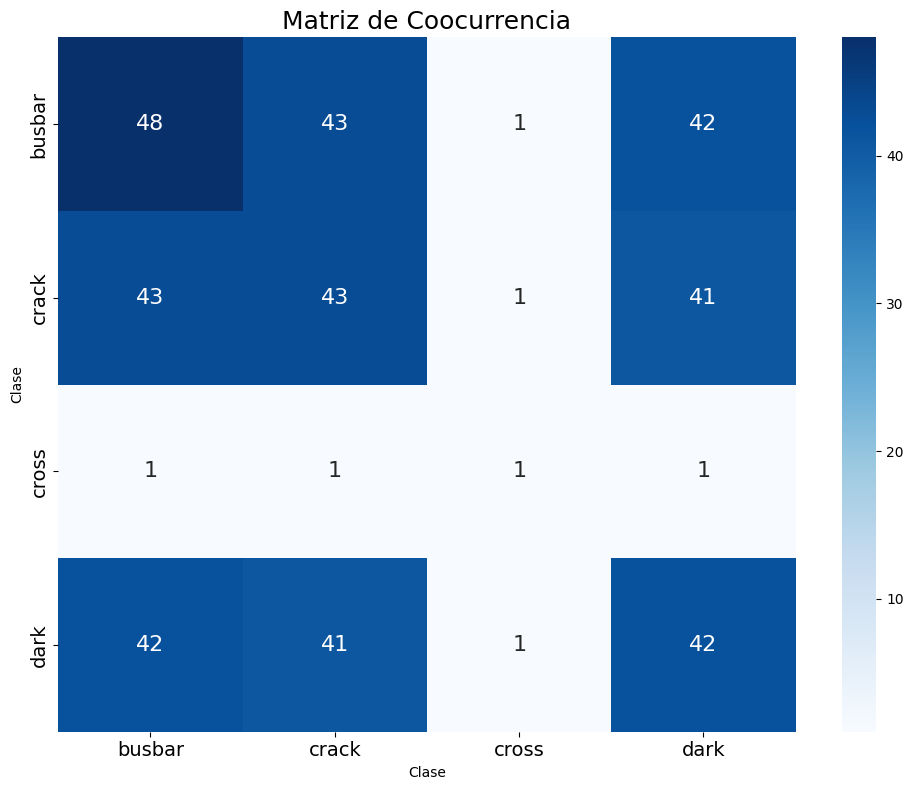

In [67]:
# Crear un reporte en PDF con los resultados
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

# Ruta donde se guardará el reporte
reporte_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'
reporte_pdf = f'{reporte_path}/reporte_mono.pdf'

# Funciones para guardar las visualizaciones como imágenes
def save_heatmap_images():
    heatmap_busbar = generate_heatmap(masks_each, class_index=0)
    heatmap_crack = generate_heatmap(masks_each, class_index=1)
    heatmap_dark = generate_heatmap(masks_each, class_index=3)

    plt.imsave(f'{reporte_path}/heatmap_busbar.png', heatmap_busbar, cmap='viridis')
    plt.imsave(f'{reporte_path}/heatmap_crack.png', heatmap_crack, cmap='viridis')
    plt.imsave(f'{reporte_path}/heatmap_dark.png', heatmap_dark, cmap='viridis')

# Guardar los mapas de calor como imágenes
save_heatmap_images()
# Guardar la matriz de coocurrencia como imagen
plot_cooccurrence_matrix(cooccurrence_matrix, class_names, f'{reporte_path}/cooccurrence_matrix.png')


# Función para crear una tabla en el PDF
def create_table(dataframe):
    data = [dataframe.columns.tolist()] + dataframe.values.tolist()
    table = Table(data)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    return table

# Función para generar el reporte en PDF
def generate_pdf_report():
    pdf = SimpleDocTemplate(reporte_pdf, pagesize=letter)
    elements = []
    styles = getSampleStyleSheet()

    # Añadir título
    styles = getSampleStyleSheet()
    title = Paragraph("Reporte de Resultados de Análisis de Imágenes EL", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 12))

    # Agregar los mapas de calor al PDF
    elements.append(Paragraph("Mapas de Calor", styles['Heading1']))
    elements.append(Paragraph("Mapa de Calor de Barras Colectoras", styles['Heading3']))
    elements.append(Image(f'{reporte_path}/heatmap_busbar.png', width=200, height=200))
    elements.append(Paragraph("Mapa de Calor de Grietas", styles['Heading3']))
    elements.append(Image(f'{reporte_path}/heatmap_crack.png', width=200, height=200))
    elements.append(Paragraph("Mapa de Calor de Zonas Oscuras", styles['Heading3']))
    elements.append(Image(f'{reporte_path}/heatmap_dark.png', width=200, height=200))
    print(f"Mapas de calor agregados al reporte")

    # Agregar la matriz de coocurrencia al PDF
    elements.append(Paragraph("Matriz de Coocurrencia", styles['Heading1']))
    elements.append(Image(f'{reporte_path}/cooccurrence_matrix.png', width=400, height=300))
    print(f"Matriz de coocurrencia agregada al reporte")

    # Añadir estadísticas de conteo de píxeles por imagen
    elements.append(Paragraph("Estadísticas de Conteo de Píxeles por Imagen", styles['Heading2']))
    # Agregar un párrafo con la descripción de las estadísticas
    elements.append(Paragraph("Las siguientes tablas muestran el conteo de píxeles por imagen para cada clase.", styles['Normal']))
    elements.append(Spacer(1, 12))
    elements.append(create_table(image_statistics))
    print(f"Estadísticas de Conteo de Píxeles por Imagen agregadas al reporte")

    # Añadir estadísticas de porcentaje de área por imagen
    elements.append(Paragraph("Estadísticas de Porcentaje de Área por Imagen", styles['Heading2']))
    # Agregar un párrafo con la descripción de las estadísticas
    elements.append(Paragraph("Las siguientes tablas muestran el porcentaje de área cubierta por cada clase en cada imagen.", styles['Normal']))
    elements.append(Spacer(1, 12))
    elements.append(create_table(area_statistics))
    print(f"Estadísticas de Porcentaje de Área por Imagen agregadas al reporte")

    # Añadir estadísticas de CrackCell
    elements.append(Paragraph("Estadísticas de CrackCell", styles['Heading2']))
    # Agregar un párrafo con la descripción de las estadísticas
    elements.append(Paragraph("Las siguientes tablas muestran las estadísticas extraídas por CrackCell para cada imagen.", styles['Normal']))
    elements.append(Spacer(1, 12))
    elements.append(create_table(crackcell_stats))
    print(f"Estadísticas de CrackCell agregadas al reporte")

    # Añadir la imagen del panel completo con las predicciones
    #page_width, page_height = letter
    elements.append(Paragraph("Panel de Predicciones", styles['Heading1']))
    elements.append(Paragraph("El panel completo muestra las imágenes originales con las predicciones superpuestas.", styles['Normal']))
    elements.append(Image(f'{reporte_path}/panel_predictions_mono.png', width=500, height=630))
    print(f"Panel de Predicciones agregado al reporte")

    pdf.build(elements)


# Generar el reporte en PDF
generate_pdf_report()
print(f"Reporte PDF generado en: {reporte_pdf}")

Para analizar el porcentaje de área inactiva de una celda se requiere crear una imagen de anotaciones `annImage` con las máscaras de las clases `crack` y `busbar`, esta imagen de anotaciones debe ser almacenada  con el mismo nombre que la imagen de la celda, para facilitar el posterior análisis. Tal vez lo más sencillo sea copiar la imagen original de la celda y almacenarla en un nuevo directorio con un nuevo nombre, el nombre debería asignarse de dorma automática.

Hasta ahora he estado empleando las predicciones del modelo para generar las estadísticas por imagen, pero cuento con la clase `CrackCell` que permite extraer el área inactiva de una celda y puede encontrar la longitud en píxeles, por lo que puedo emplear esta clase para generar las estadísticas por celda. Un punto importante, es que esta clase requiere la imagen de anotaciones `annImage`, con las máscaras de las clases `crack` y `busbar`, para poder extraer la longitud de la grieta, esta imagen de anotaciones debe ser almacenada  con el mismo nombre que la imagen original. Como trabaja con la imagen original, esta clase trabaja con las dimensiones originales de la imagen. A continuación muestro el código empleado para crear las imágenes de anotaciones.
    
    ```python

    ```

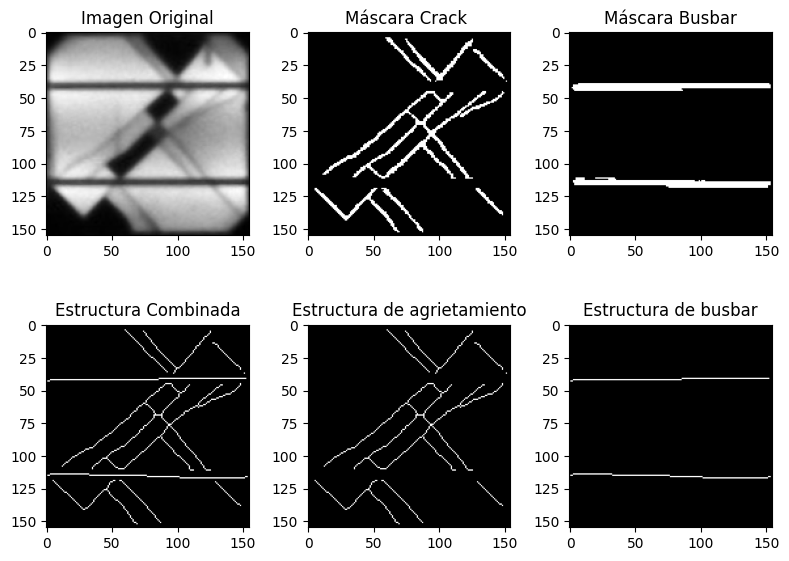

In [57]:
img_path = images_path + '/image/Image22.png'
ann_path = images_path + '/ann/annImage22.png'
# Crear una instancia de CrackCell
crackcell = CrackCell(img_path,
                      ann_path,
                      crack_inx = 100,
                      busbar_inx = 10,
                      busbar_num=2)

# Visualización de la imagen original y las máscaras de crack y busbar
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0, 0].imshow(crackcell.img, 'gray')
axes[0, 0].set_title('Imagen Original')
axes[0, 1].imshow(crackcell.crack, 'gray')
axes[0, 1].set_title('Máscara Crack ')
axes[0, 2].imshow(crackcell.busbar, 'gray')
axes[0, 2].set_title('Máscara Busbar')

axes[1, 0].imshow(crackcell.ske_merge, 'gray')
axes[1, 0].set_title('Estructura Combinada')
axes[1, 1].imshow(crackcell.ske_crack, 'gray')
axes[1, 1].set_title('Estructura de agrietamiento')
axes[1, 2].imshow(crackcell.ske_busbar, 'gray')
axes[1, 2].set_title('Estructura de busbar')

plt.tight_layout()

Extracción de características de las grietas: porcentaje de área inactiva de la celda

31.263267429760667 % de la celda está inactiva
Grieta de 648 pixels de longitud 


{'inactive_prop': 0.31263267429760666,
 'crack_length': 648,
 'brightness_cell': 0.4851803880761461,
 'brightness_inactive_only': 0.29642693983464774}

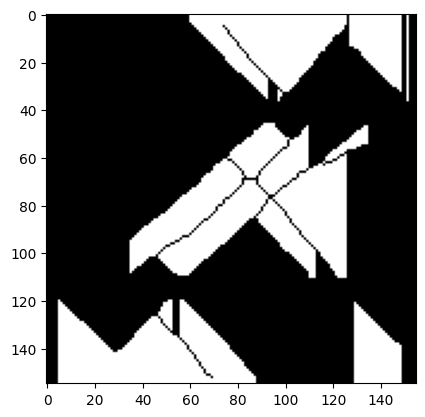

In [58]:
# Extracción del área inactiva
inactive_area, inactive_prop = crackcell.extract_inactive_area()
plt.imshow(inactive_area, "gray")
print("{} % de la celda está inactiva".format(inactive_prop*100))

# Extracción de la longitud de la grieta
crack_length = crackcell.extract_crack_length()
print("Grieta de {} pixels de longitud ".format(crack_length))

# Extracción del brillo. Existen tres modos:
    # 1. avg_all: brillo promedio de toda la imagen
    # 2. avg_inactive: brillo promedio de la región inactiva y trata el área activa como 1
    # 3. avg_inactive_only: brillo promedio solo del área inactiva y devuelve 1 para las celdas intactas

brightness = crackcell.extract_brightness(mode='avg_all')
#brightness
# Extracción de todas las funciones a la vez
crackcell.extract_features()

Plan en pseudocódigo:  
* Crear las imágenes de anotaciones.
* Inicializar una lista para almacenar las estadísticas.
* Iterar sobre todas las imágenes y usar CrackCell para extraer las estadísticas.
* Almacenar las estadísticas en la lista.
* Convertir la lista de estadísticas en un DataFrame de pandas.
* Guardar el DataFrame en un archivo CSV.*